In [1]:
# to import notbook files
import nbimporter

# from extract import extract_data
from transform import clean_preprocess_data, train_xgboost_model,train_and_evaluate_models,plot_results,generate_maintenance_analysis
from load import gen_random_input_data, upload_dataframe_to_s3
from config import Config
import boto3
from sklearn.model_selection import train_test_split

In [2]:
if Config.AWS_ACCESS_KEY_ID and Config.AWS_SECRET_ACCESS_KEY and Config.AWS_DEFAULT_REGION:
    s3_client = boto3.client(
        's3',
        aws_access_key_id=Config.AWS_ACCESS_KEY_ID,
        aws_secret_access_key=Config.AWS_SECRET_ACCESS_KEY,
        region_name=Config.AWS_DEFAULT_REGION
    )
else:
    # Default configuration if no credentials provided
    s3_client = boto3.client('s3')

DataFrame successfully uploaded to S3 bucket 'vehicles-sensor-data' as 'input-data/sensor_data.csv'.
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   vehicle_id            1000 non-null   object        
 1   timestamp             1000 non-null   datetime64[ns]
 2   engine_temperature    1000 non-null   float64       
 3   tire_pressure         1000 non-null   float64       
 4   engine_rpm            1000 non-null   float64       
 5   vehicle_speed         1000 non-null   float64       
 6   mileage               1000 non-null   float64       
 7   maintenance_required  1000 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 70.3+ KB
None
                        timestamp  engine_temperature  tire_pressure  \
count                        1000         1000.000000    100

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


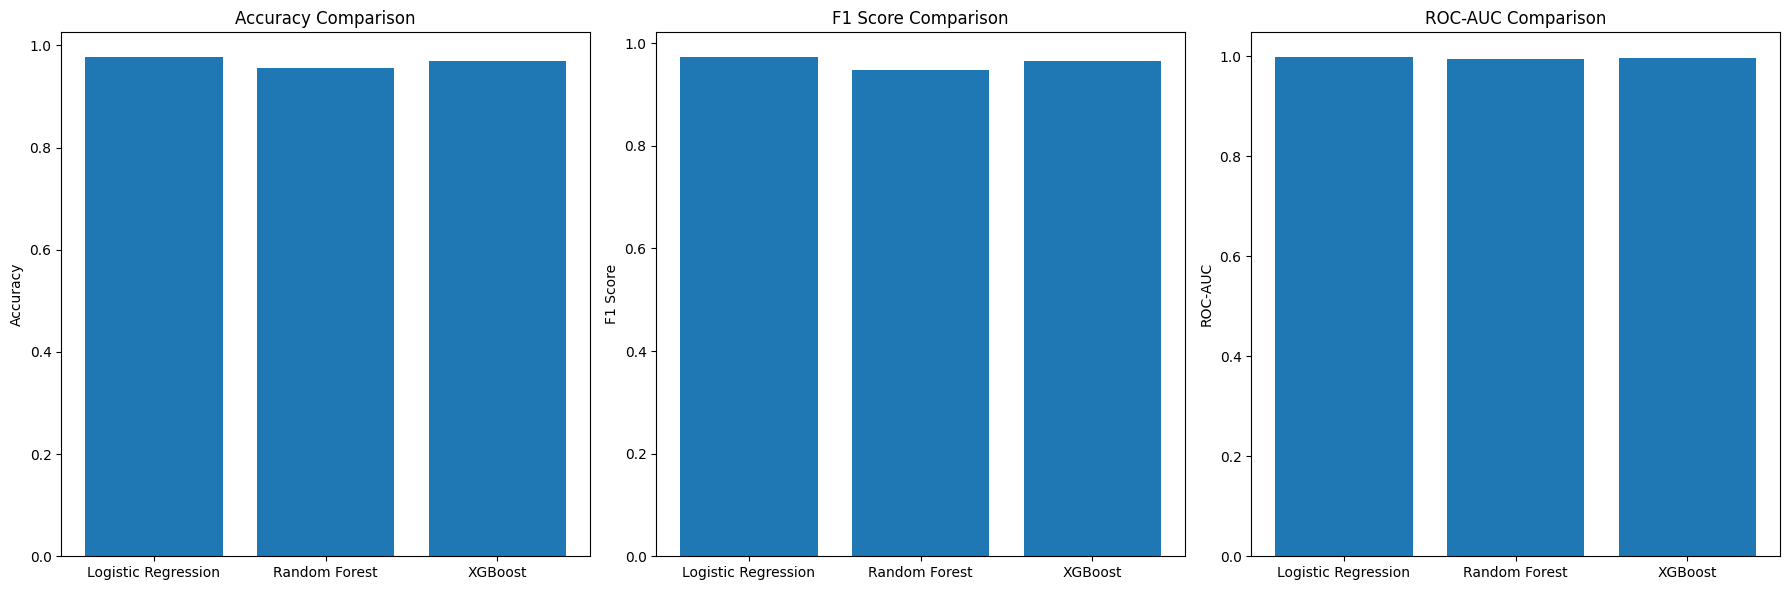

<Figure size 1200x800 with 0 Axes>

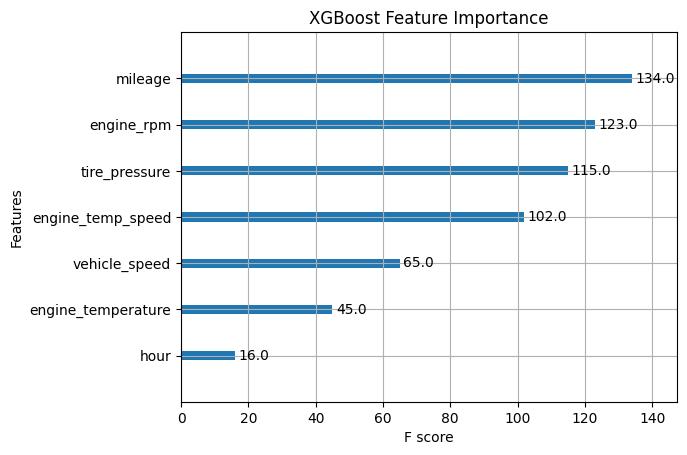

DataFrame successfully uploaded to S3 bucket 'vehicles-sensor-data' as 'output-data/model_comparision_output.csv'.
DataFrame successfully uploaded to S3 bucket 'vehicles-sensor-data' as 'output-data/xgboost_feature_imp_output.csv'.
DataFrame successfully uploaded to S3 bucket 'vehicles-sensor-data' as 'output-data/maintenance_analysis_output.csv'.
ETL workflow completed successfully!


In [3]:

def etl_workflow():
    """
    Executes the complete ETL workflow.
    """
    try:
        
        # Upload the generated random data to s3 bucket
        Config.RANDOM_INPUT_DATA = gen_random_input_data()
        
        # Upload the randomply generated data to the s3 bucket
        upload_dataframe_to_s3(
            df=Config.RANDOM_INPUT_DATA,
            bucket=Config.BUCKET_NAME,
            s3_client = s3_client,
            object_name=Config.INPUT_FILE_NAME,
        )
        
        # Step 1: Extract
        # We can extract or wen use the  Config.RANDOM_INPUT_DATA data directly
        """ Config.SENSOR_INPUT_DF = extract_data(
            bucket_name=Config.BUCKET_NAME,
            file_key=Config.INPUT_FILE_NAME,
            s3_client = s3_client
        ) """
        
        # To learn about the data basics
        print( Config.RANDOM_INPUT_DATA.info())
        print( Config.RANDOM_INPUT_DATA.describe())
    
        # Step 2: Transform
        Config.SENSOR_PROCESSED_DF = clean_preprocess_data(Config.RANDOM_INPUT_DATA)
        
        Config.MAINTENANCE_ANALYSIS = generate_maintenance_analysis( Config.SENSOR_PROCESSED_DF)
        
        #To find the best model that fits
        # Define features and target
        X = Config.SENSOR_PROCESSED_DF.drop(columns=['maintenance_required', 'vehicle_id', 'timestamp'])
        y = Config.SENSOR_PROCESSED_DF['maintenance_required']

        # Split data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        Config.MODEL_COMPARISION = train_and_evaluate_models(X_train, X_test, y_train, y_test)
        plot_results(Config.MODEL_COMPARISION)
        
        Config.XGBOOST_FEATURE_IMPORTANCE = train_xgboost_model(X_test,X_train, y_test, y_train)

        # Step 3: Load:  Upload output to S3 bucket
        
        upload_dataframe_to_s3(
            df=Config.MODEL_COMPARISION,
            bucket=Config.BUCKET_NAME,
            s3_client = s3_client,
            object_name=Config.OUTPUT_MODEL_COMPARISION,
        )
        upload_dataframe_to_s3(
            df=Config.XGBOOST_FEATURE_IMPORTANCE,
            bucket=Config.BUCKET_NAME,
            s3_client = s3_client,
            object_name=Config.OUTPUT_XGBOOST_FEATURE_IMPORTANCE,
        )
        upload_dataframe_to_s3(
            df=Config.MAINTENANCE_ANALYSIS,
            bucket=Config.BUCKET_NAME,
            s3_client = s3_client,
            object_name=Config.OUTPUT_MAINTENANCE_ANALYSIS,
        )
        print("ETL workflow completed successfully!") 
    except Exception as e:
        print(f"ETL workflow failed: {e}")

# Run the ETL workflow
if __name__ == "__main__":
    etl_workflow()
    
    
#TODO: Add visualisation to Quicksight
